<a href="https://colab.research.google.com/github/ykato27/Segmentation/blob/main/3_9_pix2pix_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pix2pixによるセグメンテーション画像の写真化

Photographing Segmented Images by pix2pix


Keras-TensorFlow で実装します．

こちらのサイトを参考にしています．

https://phillipi.github.io/pix2pix

It is implemented in Keras-TensorFlow.

The above site is used as a reference.



##Cityscapes のデータセットをダウンロード

[Cityscapes training set](https://www.cityscapes-dataset.com/)から作成した2975枚の画像

Download the Cityscapes dataset.


2975 images created from [Cityscapes training set](https://www.cityscapes-dataset.com/)



In [1]:
import os # pythonコマンドでディレクトリを操作するためのモジュール

#作業ディレクトリの作成
if not os.path.exists('./pix2pix'):
  os.makedirs('./pix2pix')
  %cd /content/pix2pix/

#データセットをダウンロード＆解凍
if not os.path.exists('./download'):
  #作業ディレクトリを作成して移動
  os.makedirs('./download')
  os.chdir('./download')
  !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/cityscapes.tar.gz
  !tar xzf cityscapes.tar.gz



/content/pix2pix
--2021-09-25 12:30:52--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/cityscapes.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103441232 (99M) [application/x-gzip]
Saving to: ‘cityscapes.tar.gz’

cityscapes.tar.gz   100%[===================>]  98.65M  4.12MB/s    in 25s     

2021-09-25 12:31:18 (3.98 MB/s) - ‘cityscapes.tar.gz’ saved [103441232/103441232]



ダウンロードした画像を確認

Check the downloaded images

In [2]:
import numpy as np
import cv2
#サポートバッチのインポートImporting support patch
from google.colab.patches import cv2_imshow

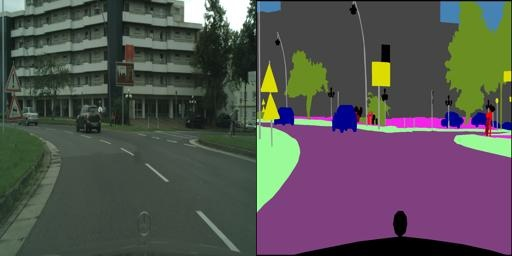

In [3]:
imga= cv2.imread('/content/pix2pix/download/cityscapes/train/1.jpg')
cv2_imshow(imga)

#画像を加工 Processing images

Processing images to create pairs of the processed image and the original landscape photo for pix2pix.


In [4]:
def transform(files):
  '''
  files      :ファイル名のリスト
  imgs       :元の画像
  gimgs      :加工した画像
  two_images :元の画像と加工した画像を並べた画像
  '''
  images =[]

  #すべての画像ファイルについて以下を実行
  for imgfile in files:
    img = cv2.imread(imgfile) #cv2で読み込み
    img = cv2.resize(img, (256,128))# (256,128,3)型にサイズ変更
    images.append(img)
  return images

In [5]:
import numpy as np
import glob
import h5py

import cv2
import os
import sys

# 作業のルートディレクトリ
ROOT_DIR = os.path.abspath("/content/pix2pix/")
# 画像が保存してあるディレクトリ
INPUT_DIR = os.path.join(ROOT_DIR, "download/cityscapes/")
# 処理した画像のディレクトリ
OUTPUT_DIR = os.path.join(ROOT_DIR, "gen_images/")

!rm -rf /content/pix2pix/gen_images
os.makedirs(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR+'train/')
os.makedirs(OUTPUT_DIR+'val/')
  
# 画像が保存してあるディレクトリからすべてのファイル名を取得 Get all file names from the directory where the images are stored.
files = glob.glob(INPUT_DIR+'*/*.jpg')
print(files)
images = transform(files)
len(images)

['/content/pix2pix/download/cityscapes/val/133.jpg', '/content/pix2pix/download/cityscapes/val/300.jpg', '/content/pix2pix/download/cityscapes/val/98.jpg', '/content/pix2pix/download/cityscapes/val/462.jpg', '/content/pix2pix/download/cityscapes/val/250.jpg', '/content/pix2pix/download/cityscapes/val/390.jpg', '/content/pix2pix/download/cityscapes/val/293.jpg', '/content/pix2pix/download/cityscapes/val/330.jpg', '/content/pix2pix/download/cityscapes/val/424.jpg', '/content/pix2pix/download/cityscapes/val/200.jpg', '/content/pix2pix/download/cityscapes/val/282.jpg', '/content/pix2pix/download/cityscapes/val/372.jpg', '/content/pix2pix/download/cityscapes/val/60.jpg', '/content/pix2pix/download/cityscapes/val/351.jpg', '/content/pix2pix/download/cityscapes/val/228.jpg', '/content/pix2pix/download/cityscapes/val/81.jpg', '/content/pix2pix/download/cityscapes/val/323.jpg', '/content/pix2pix/download/cityscapes/val/44.jpg', '/content/pix2pix/download/cityscapes/val/451.jpg', '/content/pix2p

3475

In [6]:
#トレーニングデータと評価データをランダムに取り直す Randomly re-take training data and evaluation data
perm = np.random.permutation(len(images))
images = np.array(images)[perm]
num_test = 50  #テストデータの枚数
val_images = images[-num_test:]
images = images[:-num_test]

#作成した画像を保存 Save the created image
for i in range(len(images)):
  cv2.imwrite(OUTPUT_DIR+'train/{}.jpg'.format(i),images[i])
for i in range(len(val_images)):
  cv2.imwrite(OUTPUT_DIR+'val/{}.jpg'.format(i),val_images[i])


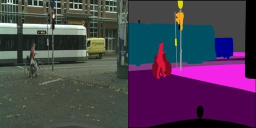

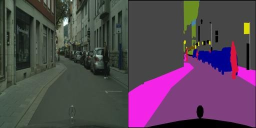

In [7]:
#作成した画像を確認 Check the created image
i = 1

cv2_imshow(images[i])
cv2_imshow(val_images[i])
#cv2_imshow(test_two_images[i])


## Kerasによるpix2pixの実装

Implementation of pix2pix with Keras

In [8]:
import tensorflow.keras.backend as K
K.clear_session()

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Reshape, Activation, Flatten
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.initializers import RandomNormal

In [9]:
# Discriminatorの定義
#  (128,128,3)のセグメンターションと(128,128,3)のカラー画像を入力し，本物か偽物か判定する
# Input (128,128,3) segmentation and (128,128,3) color images to determine if they are real or fake.

def BASIC_D(nc_in=3, nc_out=3, ndf=64, max_layers=3):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """
    channel_axis=-1    
    input_a, input_b = Input(shape=(128, 128, nc_in)), Input(shape=(128, 128, nc_out))
    _ = Concatenate(axis=channel_axis)([input_a, input_b])
    _ = Conv2D(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = Conv2D(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        #_ = BatchNormalization()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = Conv2D(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    #_ = BatchNormalization()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = Conv2D(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid") (_)    
    return Model(inputs=[input_a, input_b], outputs=_, name='Discriminator')

In [10]:
# Generatorの定義
# (128,128,3)型の入力に対するU-net  U-net for input of type (128,128,3)
# オリジナルは(256,256,3)型なので畳み込みを1段階減らしている


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Conv2DTranspose, Cropping2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Activation, Dropout

def UNet_G(input_channel_count=3, output_channel_count=3, first_layer_filter_count=64):
    
  INPUT_IMAGE_SIZE = 128
  CONCATENATE_AXIS = -1
  CONV_FILTER_SIZE = 4
  CONV_STRIDE = 2
  DECONV_FILTER_SIZE = 2
  DECONV_STRIDE = 2

  # (128 x 128 x input_channel_count)
  inputs = Input((INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE, input_channel_count))

  # エンコーダーの作成
  # (64 x 64 x N)
  enc1 = Conv2D(first_layer_filter_count, CONV_FILTER_SIZE, strides=CONV_STRIDE, padding='same')(inputs)

#  # (64 x 64 x 2N)
#  filter_count = first_layer_filter_count*2
#  enc2 = _add_encoding_layer(filter_count, enc1)

  # (32 x 32 x 4N)
  filter_count = first_layer_filter_count*4
  enc3 = _add_encoding_layer(filter_count, enc1)

  # (16 x 16 x 8N)
  filter_count = first_layer_filter_count*8
  enc4 = _add_encoding_layer(filter_count, enc3)

  # (8 x 8 x 8N)
  enc5 = _add_encoding_layer(filter_count, enc4)

  # (4 x 4 x 8N)
  enc6 = _add_encoding_layer(filter_count, enc5)

  # (2 x 2 x 8N)
  enc7 = _add_encoding_layer(filter_count, enc6)

  # (1 x 1 x 8N)
  enc8 = _add_encoding_layer(filter_count, enc7)

  # デコーダーの作成
  # (2 x 2 x 8N)
  dec1 = _add_decoding_layer(filter_count, True, enc8)
  dec1 = Concatenate(axis=CONCATENATE_AXIS)([dec1, enc7])

  # (4 x 4 x 8N)
  dec2 = _add_decoding_layer(filter_count, True, dec1)
  dec2 = Concatenate(axis=CONCATENATE_AXIS)([dec2, enc6])

  # (8 x 8 x 8N)
  dec3 = _add_decoding_layer(filter_count, True, dec2)
  dec3 = Concatenate(axis=CONCATENATE_AXIS)([dec3, enc5])

  # (16 x 16 x 8N)
  dec4 = _add_decoding_layer(filter_count, False, dec3)
  dec4 = Concatenate(axis=CONCATENATE_AXIS)([dec4, enc4])

  # (32 x 32 x 4N)
  filter_count = first_layer_filter_count*4
  dec5 = _add_decoding_layer(filter_count, False, dec4)
  dec5 = Concatenate(axis=CONCATENATE_AXIS)([dec5, enc3])

#  # (64 x 64 x 2N)
#  filter_count = first_layer_filter_count*2
#  dec6 = _add_decoding_layer(filter_count, False, dec5)
#  dec6 = Concatenate(axis=CONCATENATE_AXIS)([dec6, enc2])

  # (64 x 64 x N)
  filter_count = first_layer_filter_count
  dec7 = _add_decoding_layer(filter_count, False, dec5)
  dec7 = Concatenate(axis=CONCATENATE_AXIS)([dec7, enc1])

  # (128 x 128 x output_channel_count)
  #dec8 = BatchNormalization()(dec7)
  dec8 = Activation(activation='relu')(dec7)
  dec8 = Dropout(0.5)(dec8)
  dec8 = Conv2DTranspose(output_channel_count, DECONV_FILTER_SIZE, strides=DECONV_STRIDE)(dec8)
  dec8 = Activation(activation='tanh')(dec8)

  return Model(inputs=inputs, outputs=dec8, name='Generator')

def _add_encoding_layer(filter_count, sequence):
    #new_sequence = BatchNormalization()(sequence)
    new_sequence = LeakyReLU(0.2)(sequence)
    new_sequence = Conv2D(filter_count, 4, strides=2, padding="same")(new_sequence)    
    return new_sequence
def _add_decoding_layer(filter_count, add_drop_layer, sequence):
    #new_sequence = BatchNormalization()(sequence)
    new_sequence = Activation(activation='relu')(sequence)
    if add_drop_layer:
        new_sequence = Dropout(0.5)(new_sequence)
    new_sequence = Conv2DTranspose(filter_count, 4, strides=2, padding='same', 
                                    kernel_initializer='he_uniform')(new_sequence)
    return new_sequence

In [11]:
# netD: Discriminator

netD = BASIC_D()
netD.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
First (Conv2D)                  (None, 64, 64, 64)   6208        concatenate[0][0]    

In [12]:
# netG: Generator

netG = UNet_G()
netG.summary()


Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 256)  262400      leaky_re_lu_4[0][0]              
__________________________________________________________________________________________

GeneratorとDiscriminatorを連結したモデルの作成

識別器への入力が生成画像（偽画像）の場合にしか使わないので，連結したモデルへの入力はセグメンテーション画像のみです．出力は識別器の出力と生成画像のペア．

Creating a model that concatenates the Generator and Discriminator

The input to the combined model is only the segmentation image, since the input to the discriminator is only used if it is the generator image (false image). The output is a pair of the output of the discriminator and the generated image.

In [13]:
input_G = Input((128, 128, 3))
input_fake = netG(input_G)
output_D = netD([input_G, input_fake])
netGD = Model(inputs=[input_G], outputs=[output_D, input_fake])
netGD.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Generator (Functional)          (None, 128, 128, 3)  53225091    input_4[0][0]                    
__________________________________________________________________________________________________
Discriminator (Functional)      (None, 14, 14, 1)    2766913     input_4[0][0]                    
                                                                 Generator[0][0]                  
Total params: 55,992,004
Trainable params: 55,992,004
Non-trainable params: 0
__________________________________________________________________________________________________


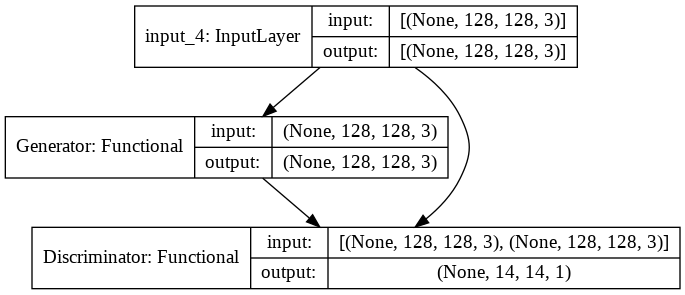

In [14]:
from tensorflow.keras.utils import plot_model

plot_model(netGD, to_file='model.png', show_shapes = True)

In [15]:
# Discriminator の損失関数はbinary_crossentropy
# Gen-Desの損失関数は， Discriminatorのbinary_crossentropy + 100 * Generatorの平均L1誤差

from tensorflow.keras.optimizers import Adam
netD.trainable = True
netD.compile(Adam(lr=0.0002, beta_1=0.5), loss=['binary_crossentropy'], loss_weights=[0.5], metrics=['accuracy'])

# ややこしいが，コンパイルした後でtrainableを変えてもコンパイルしたものには反映されないので，
# netDのパラメータはnetD.fit()やnetD.train_on_batch()で更新される
# It's complicated, but if the trainable is changed after compiling, it won't be reflected in the compiled one, 
# so netD parameters will be updated by netD.fit() and netD.train_on_batch().

netD.trainable = False
netGD.compile(Adam(lr=0.0002, beta_1=0.5), loss={'Discriminator':'binary_crossentropy', 'Generator': 'mae'}, 
              loss_weights=[1,100], 
              metrics={'Discriminator':'accuracy', 'Generator': 'mae'})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
# 保存してある画像の読み込み Loading the saved images

from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)
def read_image(fn, direction=0):
    im = Image.open(fn)
    arr = np.array(im)/255*2-1
    w=128
    h=128
    imgA = arr[:, 128:, :]
    imgB = arr[:, :128, :]
    if randint(0,1):
        imgA=imgA[:,::-1]
        imgB=imgB[:,::-1]
    if direction==0:
        return imgA, imgB
    else:
        return imgB,imgA

direction = 0
trainAB = load_data('/content/pix2pix/gen_images/train/*.jpg')
valAB = load_data('/content/pix2pix/gen_images/val/*.jpg')
print(len(trainAB),trainAB[0],len(valAB))

3425 /content/pix2pix/gen_images/train/1042.jpg 50


In [17]:
# ミニバッチを生成する関数　next()で呼び出す A function creating minibatches (called by net())
def minibatch(dataAB, batchsize=10, direction=0, augmentation=False):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[j], direction)
            
            if augmentation:
              # データ増大
              # 左右反転
              if np.random.rand() < 0.5:
                imgA,imgB = imgA[:, ::-1, :], imgB[:, ::-1, :]
              
              # 拡大して切り抜き
              if np.random.rand() < 0.7:
                zoom = np.random.randint(129,192) 
                imgA, imgB = cv2.resize(imgA, (zoom,zoom)), cv2.resize(imgB, (zoom,zoom))
                h, w, _ = imgA.shape
                crop_size = 128

                # 0~(192-128)の間で画像のtop, leftを決める
                top = np.random.randint(0, h - crop_size)
                left = np.random.randint(0, w - crop_size)

                # top, leftから画像のサイズである128を足して、bottomとrightを決める
                bottom = top + crop_size
                right = left + crop_size

                # 決めたtop, bottom, left, rightを使って画像を抜き出す
                imgA, imgB = imgA[top:bottom, left:right, :], imgB[top:bottom, left:right, :]
                       
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB        
        

In [18]:
# 画像を並べて表示する関数 A function to display images in an array.
imageSize = 128
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

`minibatch()` の使用例

上段：セグメンテーション画像

下段：正解のカラー画像

How `minibatch()` works

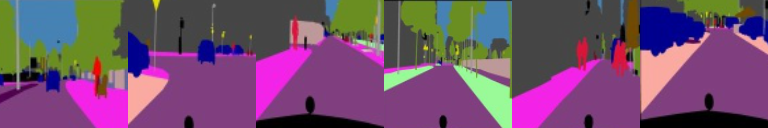

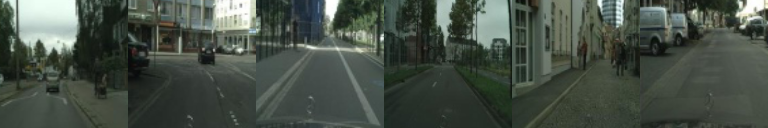

In [19]:
train_batch = minibatch(trainAB, 6, direction=direction, augmentation=True)
_, trainA, trainB = next(train_batch)
showX(trainA)
showX(trainB)
del train_batch, trainA, trainB

In [20]:
def netG_gen(A):
    return np.concatenate([netG([A[i:i+1]]) for i in range(A.shape[0])], axis=0)

##学習 Training

In [21]:
# Discriminatorの出力サイズを確認
netD.output.shape

TensorShape([None, 14, 14, 1])

学習はミニバッチのサイズを1として行うことが多いようです．
約900ペアの学習データがあるので，1エポック学習するのに5分程かかります．それを2エポック学習してみます．

結果の表示は学習データ，評価用データの順で，それぞれ

上段：セグメンターション画像<br>
中段：生成画像<br>
下段：正解のカラー画像

です．

Training is often done with a mini-batch size of 1.
Since we have about 900 pairs of training data, it takes about 5 minutes to train one epoch. Let's train it for two epochs.

The results are displayed in the order of training data and evaluation data, respectively.

Top: Segmentation images<br>
Middle: generated images<br>
Bottom: color images of the correct answer



[0/1][3000] acc_D_real: 0.830206 acc_D_fake: 0.915485 acc_G: 0.084515  loss_L1: 0.215478 time: 773.446099


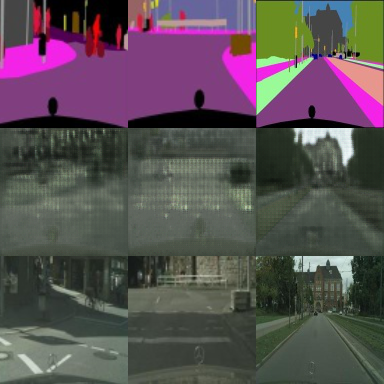

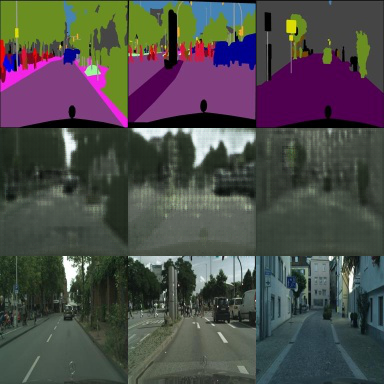

[0/1][3100] acc_D_real: 0.830953 acc_D_fake: 0.916406 acc_G: 0.083594  loss_L1: 0.215280 time: 798.023381


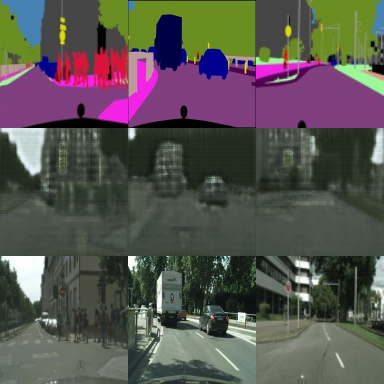

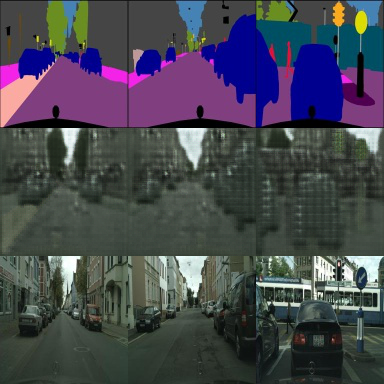

[0/1][3200] acc_D_real: 0.831239 acc_D_fake: 0.917431 acc_G: 0.082569  loss_L1: 0.214809 time: 822.772210


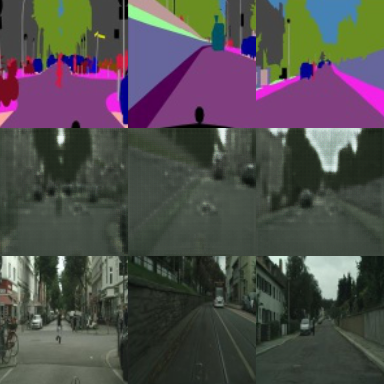

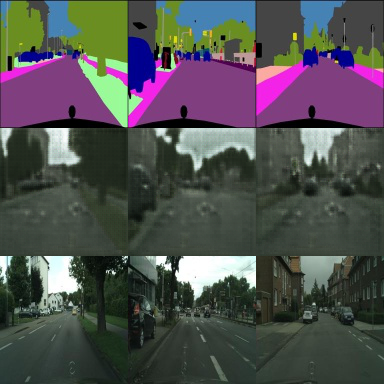

[0/1][3300] acc_D_real: 0.831934 acc_D_fake: 0.917922 acc_G: 0.082078  loss_L1: 0.214309 time: 847.441339


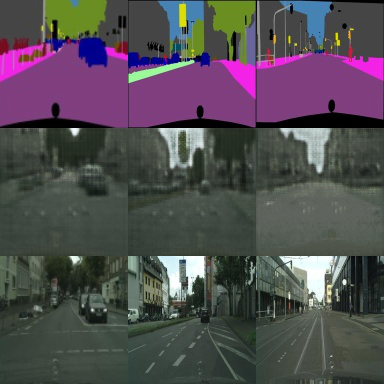

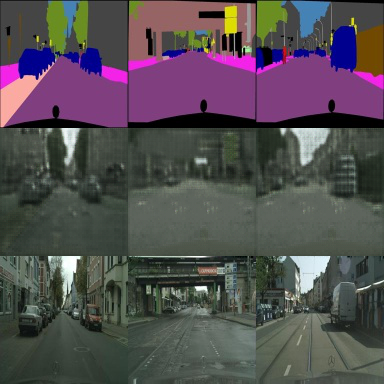

In [22]:
import time
from IPython.display import clear_output
batchSize = 1 #バッチサイズ
D_out_size = netD.output.shape[1] #パッチ（Discriminatorの出力）の大きさ 

t0 = time.time()
niter = 1 #学習するエポック数
gen_iterations = 0 #ミニバッチを生成した回数 

display_iters = min(len(trainAB)//batchSize, 100) #結果を出力する頻度
val_batch = minibatch(valAB, 3, direction) #評価用ミニバッチ
train_batch = minibatch(trainAB, batchSize, direction, augmentation=True) #学習用ミニバッチ
accD_real, accD_fake, accGD, errL1 = [], [], [], [] #精度を記録する配列

epoch = 0 
while epoch < niter: 
    epoch, trainA, trainB = next(train_batch) # trainA: 白黒画像， trainB: 正解のカラー画像 

    # 識別機に正解画像を入力した場合，出力パッチの値がすべて1になるように識別器を学習  
    netD.train_on_batch([trainA,trainB], np.ones((batchSize,D_out_size,D_out_size,1),dtype=np.int8))
    # 識別機に偽画像を入力した場合，出力パッチの値がすべて0になるように識別器を学習
    netD.train_on_batch([trainA,netG(trainA)], np.zeros((batchSize,D_out_size,D_out_size,1),dtype=np.int8))
       
    # 識別機に偽画像を入力した場合，出力パッチの値がすべて1になるように生成器を学習
    errG = netGD.train_on_batch(trainA, [np.ones((batchSize,D_out_size,D_out_size,1),dtype=np.int8),trainB])
        
    # 精度の記録
    accD_real += [np.mean(netD([trainA,trainB]) > 0.5)]
    accD_fake += [np.mean(netD([trainA,netG(trainA)]) < 0.5)]
    accGD += [np.mean(netGD([trainA])[0] > 0.5)]
    errL1 += [errG[4]]

    gen_iterations+=1

    # 途中経過の表示
    if gen_iterations%display_iters==0:
        
        # 5回に一回表示をクリアする
        if gen_iterations%(5*display_iters)==0:
            clear_output()
        
        # 精度の表示
        print('[%d/%d][%d] acc_D_real: %f acc_D_fake: %f acc_G: %f  loss_L1: %f time: %f'
        % (epoch, niter, gen_iterations, np.mean(accD_real), 
           np.mean(accD_fake), 
           np.mean(accGD), np.mean(errL1), time.time()-t0))
        
        # 画像の表示
        _, trainA, trainB = train_batch.send(3) 
        fakeB = netG_gen(trainA)
        showX(np.concatenate([trainA, fakeB, trainB], axis=0), 3)
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, fakeB, valB], axis=0), 3)
        

In [23]:
# パラメータの保存
# netD.save_weights('netD.h5')
# netG.save_weights('netG.h5')


時間がかかるので30エポック学習させたパラメータを読み込みます．

Since it takes time, load the parameters that have been learned for 30 epochs.

In [24]:
# 学習済みパラメータの読み込み
!wget https://www.dropbox.com/s/sn17b9rbcvxlhh5/netD.h5
!wget https://www.dropbox.com/s/fwqseegq8bsx3ye/netG.h5
netD.load_weights('netD.h5')
netG.load_weights('netG.h5')

--2021-09-25 12:45:54--  https://www.dropbox.com/s/sn17b9rbcvxlhh5/netD.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sn17b9rbcvxlhh5/netD.h5 [following]
--2021-09-25 12:45:55--  https://www.dropbox.com/s/raw/sn17b9rbcvxlhh5/netD.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3b696950e5abe3b0aecc033968.dl.dropboxusercontent.com/cd/0/inline/BW0UyyMRS7kbgDTYr6CSTYeR3wKVe6qesacwYfBnkraC1Fhek5dKMMm5jr9KP9n58QPizWCtOWWyMSacT8BQ-MjiBf_ljZOnq4f5Rn_-0oyXPECUcTKY9tgnZDOQTg7Cxd_X5bmX_np8MOigX9XAHgCZ/file# [following]
--2021-09-25 12:45:55--  https://uc3b696950e5abe3b0aecc033968.dl.dropboxusercontent.com/cd/0/inline/BW0UyyMRS7kbgDTYr6CSTYeR3wKVe6qesacwYfBnkraC1Fhek5dKMMm5jr9KP9n58QPizWCtOWWyMSacT8BQ-MjiBf_ljZOnq4f5Rn

予測結果を表示してみましょう．

Let's show the prediction results.

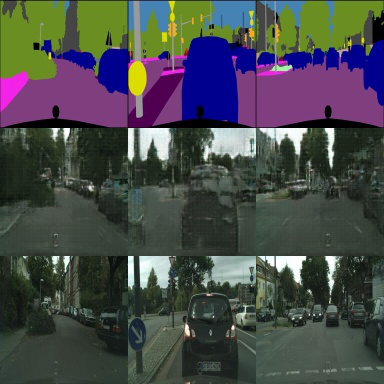

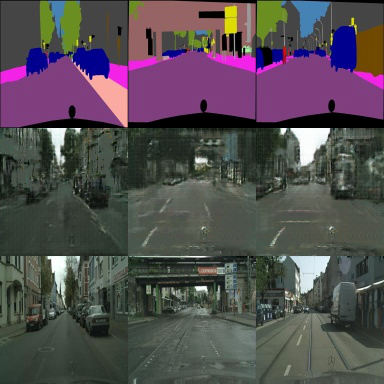

In [25]:
train_batch = minibatch(trainAB, 3, direction, augmentation=False) #学習用ミニバッチ
val_batch = minibatch(valAB, 3, direction) #評価用ミニバッチ

_, trainA, trainB = next(train_batch) 
fakeB = netG_gen(trainA)
showX(np.concatenate([trainA, fakeB, trainB], axis=0), 3)
#errL1_sum = errG_sum = errD_sum = 0

print('')
_, valA, valB = next(val_batch)
fakeB = netG_gen(valA)
showX(np.concatenate([valA, fakeB, valB], axis=0), 3)

各列上から

（学習データの）セグメンテーション画像，生成画像，元の画像

（テストデータの）セグメンテーション画像，生成画像，元の画像

となっています．

From the top of each column

the segmentation image, the generated image, and the original image
for training data

and

the segmentation image, the generated image, and the original image
dor the test data.